# Roteiro
1. Leitura dos dados
2. Criação dos datasets e dataloaders
3. Definição do modelo, otimizador e loss function
4. Definição das funções de treino, validação e teste
5. Treinamento
6. Inferência

# 1. Leitura dos dados

Carregando dataset

In [1]:
import splitfolders
splitfolders.ratio('cabo_crop', output="cabo_crop_splitted", seed=1337, ratio=(0.6, 0.2, 0.2))

Copying files: 50 files [00:00, 451.65 files/s]


# 2. Criação dos datasets e dataloaders

Criando as transformações nos dados
- resize
- normalização

O dataset de treino sofre resize e normalização de acordo com o ImageNet Dataset

In [3]:
# imports
import os
import torch
from torchvision import datasets
import torchvision.transforms as transforms

train_transform = transforms.Compose([
        transforms.Resize((224,350)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

transform = transforms.Compose([
        transforms.Resize((224,350)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

Criação dos datasets e dataloarders de treino, teste e validação

In [4]:
data_dir = 'cabo_crop_splitted'

train_dataset = datasets.ImageFolder(os.path.join(data_dir + "/train"), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir + "/val"), transform=transform)
test_dataset = datasets.ImageFolder(os.path.join(data_dir + "/test"), transform=transform)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=2, shuffle=True)

num_classes = len(train_dataset.classes)
class_names = train_dataset.classes

print(f'Quantidade de classes: {num_classes}')
print(f'Nome das classes: \n{class_names}')

Quantidade de classes: 2
Nome das classes: 
['crop_bom', 'crop_ruim']


# 3. Definido modelo, otimizador e função de perda

In [5]:
from torchvision import models
import torch.nn as nn
from torch import optim

device = torch.device('cpu')

model = models.resnet18(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
print(model)

model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 4. Definição das funções de treino, validação e teste

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from datetime import datetime
import copy
import numpy as np


def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    
def get_accuracy(model, data_loader, device):
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for inputs, labels in data_loader:

            inputs = inputs.to(device)
            labels = labels.to(device)

            output_prob = model(inputs)
            _, predicted_labels = torch.max(output_prob, 1)

            n += labels.size(0) # add batch_size num of samples being iterated
            correct_pred += (predicted_labels == labels).sum() # sum array of bools (1's are correct predictions)

    return correct_pred.float() / n

def train(train_loader, model, criterion, optimizer, device):
    model.train()
    running_loss = 0
    
    for inputs, labels in train_loader:

        optimizer.zero_grad()
        
        inputs = inputs.to(device)
        labels = labels.to(device)
    
        # Forward pass
        outputs = model(inputs) 
        loss = criterion(outputs, labels) 
        running_loss += loss.item() * inputs.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def val(val_loader, model, criterion, device):
  
    model.eval()
    running_loss = 0
    
    for inputs, labels in val_loader:
    
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass and record loss
        with torch.no_grad():
            outputs = model(inputs) 
            loss = criterion(outputs, labels) 
            running_loss += loss.item() * inputs.size(0)

    epoch_loss = running_loss / len(val_loader.dataset)
        
    return model, epoch_loss


def training_loop(model, criterion, optimizer, train_loader, valid_loader, test_dataloader, epoches, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_acc = 0.0
    best_loss = 1e10
    train_losses = []
    valid_losses = []

    # Train model and validate
    for epoch in range(epoches):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = val(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        # accuracies
        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            test_acc = get_accuracy(model, test_dataloader, device=device)
            
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                    f'Epoch: {epoch}\t'
                    f'Train loss: {train_loss:.4f}\t'
                    f'Valid loss: {valid_loss:.4f}\t'
                    f'Train accuracy: {100 * train_acc:.2f}\t'
                    f'Val accuracy: {100 * valid_acc:.2f}\t'
                    f'Test accuracy: {100 * test_acc:.2f}')

        # create a copy of our model when it test its best
        if test_acc >= best_acc:
            best_acc = test_acc
            best_model_wts = copy.deepcopy(model.state_dict())
        
    plot_losses(train_losses, valid_losses)
    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

# 5. Treinamento

10:17:39 --- Epoch: 0/tTrain loss: 0.4874	Valid loss: 0.0110	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
10:17:49 --- Epoch: 1/tTrain loss: 0.5977	Valid loss: 1.0055	Train accuracy: 83.33	Val accuracy: 80.00	Test accuracy: 100.00
10:17:59 --- Epoch: 2/tTrain loss: 0.5910	Valid loss: 0.0934	Train accuracy: 96.67	Val accuracy: 100.00	Test accuracy: 100.00
10:18:09 --- Epoch: 3/tTrain loss: 0.2530	Valid loss: 0.0255	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
10:18:19 --- Epoch: 4/tTrain loss: 0.1598	Valid loss: 0.0138	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
10:18:29 --- Epoch: 5/tTrain loss: 0.0776	Valid loss: 0.0069	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
10:18:40 --- Epoch: 6/tTrain loss: 0.0929	Valid loss: 0.0131	Train accuracy: 100.00	Val accuracy: 100.00	Test accuracy: 100.00
10:18:49 --- Epoch: 7/tTrain loss: 0.0480	Valid loss: 0.0092	Train accuracy: 100.00	Val accuracy: 100.00	Test accu

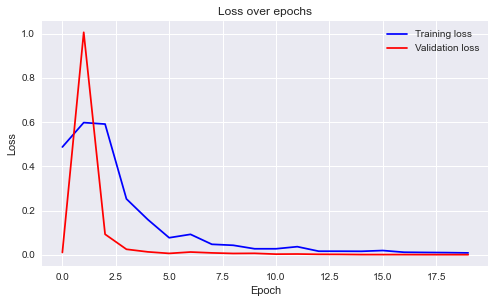

In [7]:
model = training_loop(model=model, 
    criterion=criterion, 
    optimizer=optimizer, 
    train_loader=train_dataloader, 
    valid_loader=val_dataloader, 
    test_dataloader=test_dataloader,
    epoches=20, 
    device=device, 
    print_every=1
)

torch.save(model.state_dict(), "cabos_fonte_classificador.pth")